# Sprout Social: Exploratory Data Analysis Notebook
## By Matthew Smith

### Instructions
### Imagine you’re conducting some exploratory analysis of the provided dataset. We’d love for you to answer the following questions as part of that analysis, including charts and graphs to illustrate your answers -- feel free to use whatever tool you’re most comfortable with to produce these. Please also provide any additional work/code that was part of your process.

    1)  What is our daily login rate (% of customers logging in)?
        How does this vary by day of the week? 
        
    2) How does total logins vary over time? 
       How does this vary by plan type (sprout_base_plan)?
       
    3) EXTRA CREDIT:  What is the cumulative distribution of total logins by customer? 
       Approximately how many customers account for 90% of all logins?


In [1]:
# Import statements & setting up dataframes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

csv1 = '/Users/msmith/Downloads/Sprout_File/customer_logins.csv'
csv2 = '/Users/msmith/Downloads/Sprout_File/customer_table.csv'
csv3 = '/Users/msmith/Downloads/Sprout_File/login_history.csv'

customer_logins = pd.read_csv(csv1)
customer_table = pd.read_csv(csv2)
login_history = pd.read_csv(csv3)
raw_dataframes = [customer_logins, customer_table, login_history]

In [2]:
# Looping to inspect data types of dataframes
for df in raw_dataframes:
    print(df.dtypes)
    print(" ")

customer_id    object
login_id       object
dtype: object
 
customer_id             object
age                      int64
churned                float64
sprout_base_plan        object
segment                 object
industry                object
customer_demo_given     object
twitter_profiles       float64
facebook_profiles      float64
dtype: object
 
login_id      object
login_date    object
num_logins     int64
dtype: object
 


In [3]:
# Setting data types for df features
customer_logins = customer_logins.astype({'customer_id': 'string', 'login_id': 'string'})

login_history = login_history.astype({'login_id': 'string'})
login_history['login_date'] = pd.to_datetime(login_history['login_date'])

customer_table = customer_table.astype({'customer_id': 'string'})

In [4]:
# Joining login_history with customer_logins to see which customer a user belongs to
daily_logins = login_history.merge(customer_logins, how='left', on='login_id')
daily_logins.head()

,login_id,login_date,num_logins,customer_id
0,824d5cc8275b0e892baa22ddd2ca11c306a11eb4,2017-04-01,5,f921b8670dd264aaf25873cb6cea7fff44c17201
1,33bf42de9a048d71bde1b9266f5d2357ef415775,2017-04-01,1,edbfec6a28c8b602c0aa049cd82b02bae3c6d67c
2,3d730f8df1a75d21de28cb47cba0f9f23cd34b75,2017-04-01,1,ae9cb1f32a44b15732e67d36e8c72cc5b584555a
3,4ac9b9c62e6f0a677a20ad562ea9f71e8256ca8f,2017-04-01,1,d9ae9e1e2eb36cb9631a720bd0d3caa323d07735
4,6bef3d94dd065202541d5993ba3f3583222c6b2b,2017-04-01,1,2908a195d4fc472e7b6226017fe83e3dbfcf4a53


## 1) What is our daily login rate (% of customers logging in)? How does this vary by day of the week?

In [5]:
# Grouping logins by date & aggregating customer_id
daily_login_rate = daily_logins.groupby(['login_date'])['customer_id'].count()
daily_login_rate = daily_login_rate.to_frame()
daily_login_rate = daily_login_rate.rename(columns={'customer_id': 'count_of_customer_logins'})

# Creating a daily login in percentage (daily_number_of_logins / total_number_of_customers)
daily_login_rate['percentage_of_total_customers'] = (
    daily_login_rate['count_of_customer_logins'] / (customer_logins['customer_id'].count()))

In [6]:
# Resetting date index
daily_login_rate = daily_login_rate.reset_index()

In [7]:
# Creating column for day name based on login_date
daily_login_rate['day_of_week'] = daily_login_rate['login_date'].dt.day_of_week
daily_login_rate['day_name'] = daily_login_rate['login_date'].dt.day_name()
daily_login_rate.head()

,login_date,count_of_customer_logins,percentage_of_total_customers,day_of_week,day_name
0,2017-04-01,120,0.106477,5,Saturday
1,2017-04-02,117,0.103815,6,Sunday
2,2017-04-03,437,0.387755,0,Monday
3,2017-04-04,399,0.354037,1,Tuesday
4,2017-04-05,418,0.370896,2,Wednesday


### 1A) Average Daily Login Rate is: 29.99%

In [8]:
# Answer to 1A: What is our daily login rate?
average_daily_login_rate = daily_login_rate['percentage_of_total_customers'].mean()
print('Average Daily Login Rate is: ' + str(round(average_daily_login_rate*100,2)) + "%")

Average Daily Login Rate is: 29.99%


In [9]:
# Answer to 1B: How does this vary by day of week?
avg_login_by_day_of_week = (daily_login_rate.groupby('day_name')[['day_of_week','percentage_of_total_customers']]
                            .mean()
                           )

sorted_avg_login_by_day_of_week = (avg_login_by_day_of_week.sort_values('day_of_week')
                         .reset_index())

sorted_avg_login_by_day_of_week

,day_name,day_of_week,percentage_of_total_customers
0,Monday,0.0,0.406610
1,Tuesday,1.0,0.396406
2,Wednesday,2.0,0.409051
3,Thursday,3.0,0.400177
4,Friday,4.0,0.348048
5,Saturday,5.0,0.108962
6,Sunday,6.0,0.122272


### 1B) Chart outlining change by day of week

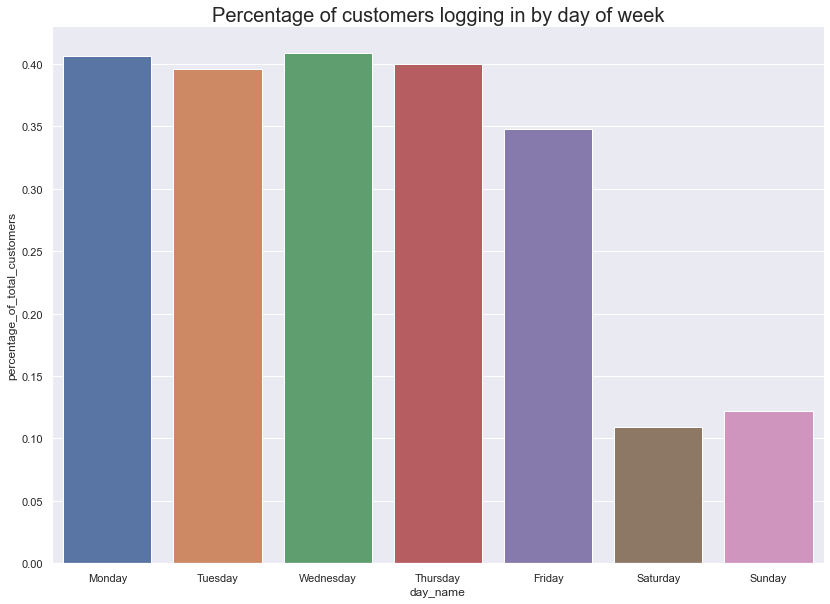

In [10]:
g = sns.catplot(data=sorted_avg_login_by_day_of_week, 
                kind="bar", 
                x="day_name", 
                y="percentage_of_total_customers",
                height=8.27, 
                aspect=11.7/8.27)
plt.title('Percentage of customers logging in by day of week', fontsize=20)
plt.show()

  ##  2) How does total logins vary over time? How does this vary by plan type (sprout_base_plan)?

In [11]:
# Expanding daily_logins table by adding data from customer_table
df = daily_logins.merge(customer_table, how='left', on='customer_id')

df.head()

,login_id,login_date,num_logins,customer_id,age,churned,sprout_base_plan,segment,industry,customer_demo_given,twitter_profiles,facebook_profiles
0,824d5cc8275b0e892baa22ddd2ca11c306a11eb4,2017-04-01,5,f921b8670dd264aaf25873cb6cea7fff44c17201,18,0.0,Deluxe,Agency,Corporate,NaN,2.0,1.0
1,33bf42de9a048d71bde1b9266f5d2357ef415775,2017-04-01,1,edbfec6a28c8b602c0aa049cd82b02bae3c6d67c,20,0.0,Premium,SMB,NaN,NaN,3.0,4.0
2,3d730f8df1a75d21de28cb47cba0f9f23cd34b75,2017-04-01,1,ae9cb1f32a44b15732e67d36e8c72cc5b584555a,8,0.0,Team,SMB,NaN,NaN,6.0,7.0
3,4ac9b9c62e6f0a677a20ad562ea9f71e8256ca8f,2017-04-01,1,d9ae9e1e2eb36cb9631a720bd0d3caa323d07735,6,0.0,Deluxe,SMB,NaN,NaN,1.0,1.0
4,6bef3d94dd065202541d5993ba3f3583222c6b2b,2017-04-01,1,2908a195d4fc472e7b6226017fe83e3dbfcf4a53,18,0.0,Enterprise,Agency,Corporate,NaN,5.0,6.0


### 2A) Chart & table outlining login changes over time period

In [12]:
# Creation of dataframe to model number of logins over time
total_logins_over_time = (df.groupby('login_date')['num_logins']
                          .sum()
                          .to_frame())

total_logins_over_time

,num_logins
login_date,
2017-04-01,151
2017-04-02,131
2017-04-03,595
2017-04-04,538
2017-04-05,564
2017-04-06,575
2017-04-07,522
2017-04-08,110
2017-04-09,162


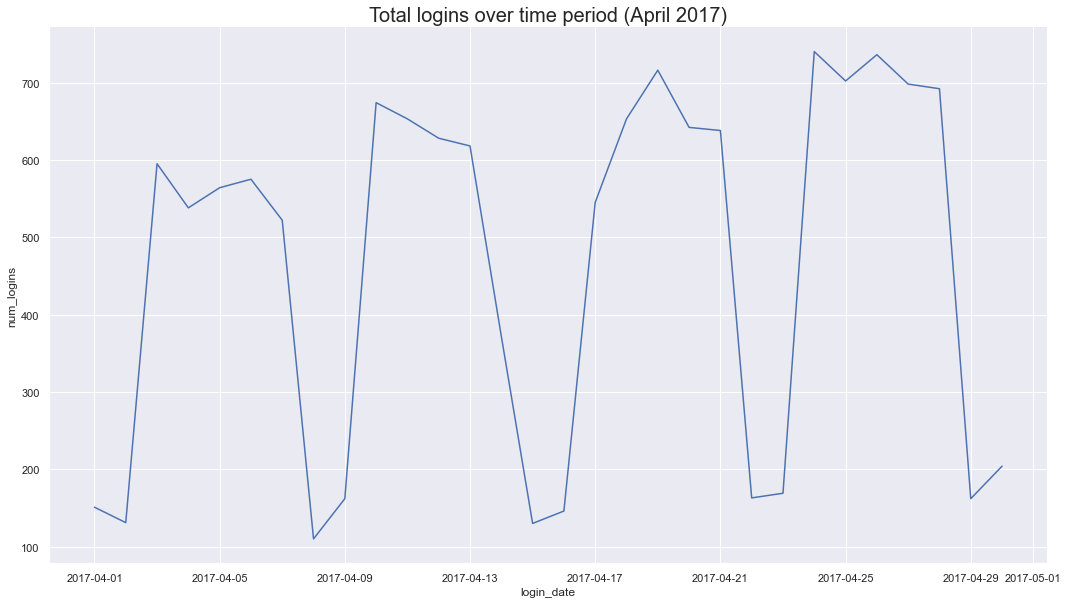

In [13]:
# Visualization of logins during the month of April
g = sns.relplot(data=total_logins_over_time, 
                kind="line", 
                x=total_logins_over_time.index,
                y="num_logins",
                height=8.27, 
                aspect=15/8.27)

plt.title('Total logins over time period (April 2017)', fontsize=20)
plt.show()

### 2B) Chart & table outlining login changes over time period by plan type

In [14]:
# Creation of dataframe to model number of logins BY PLAN TYPE over time

logins_over_time_plan_type = (df.groupby(['login_date','sprout_base_plan'])['num_logins']
                              .sum()
                              .to_frame()
                             .reset_index())

logins_over_time_plan_type.head(20)

# Uncomment for full table
# pd.set_option('display.max_rows', 150)
# logins_over_time_plan_type

,login_date,sprout_base_plan,num_logins
0,2017-04-01,Deluxe,36
1,2017-04-01,Enterprise,5
2,2017-04-01,Premium,53
3,2017-04-01,Team,48
4,2017-04-02,Deluxe,38
5,2017-04-02,Enterprise,5
6,2017-04-02,Premium,51
7,2017-04-02,Team,36
8,2017-04-03,Deluxe,109
9,2017-04-03,Enterprise,30


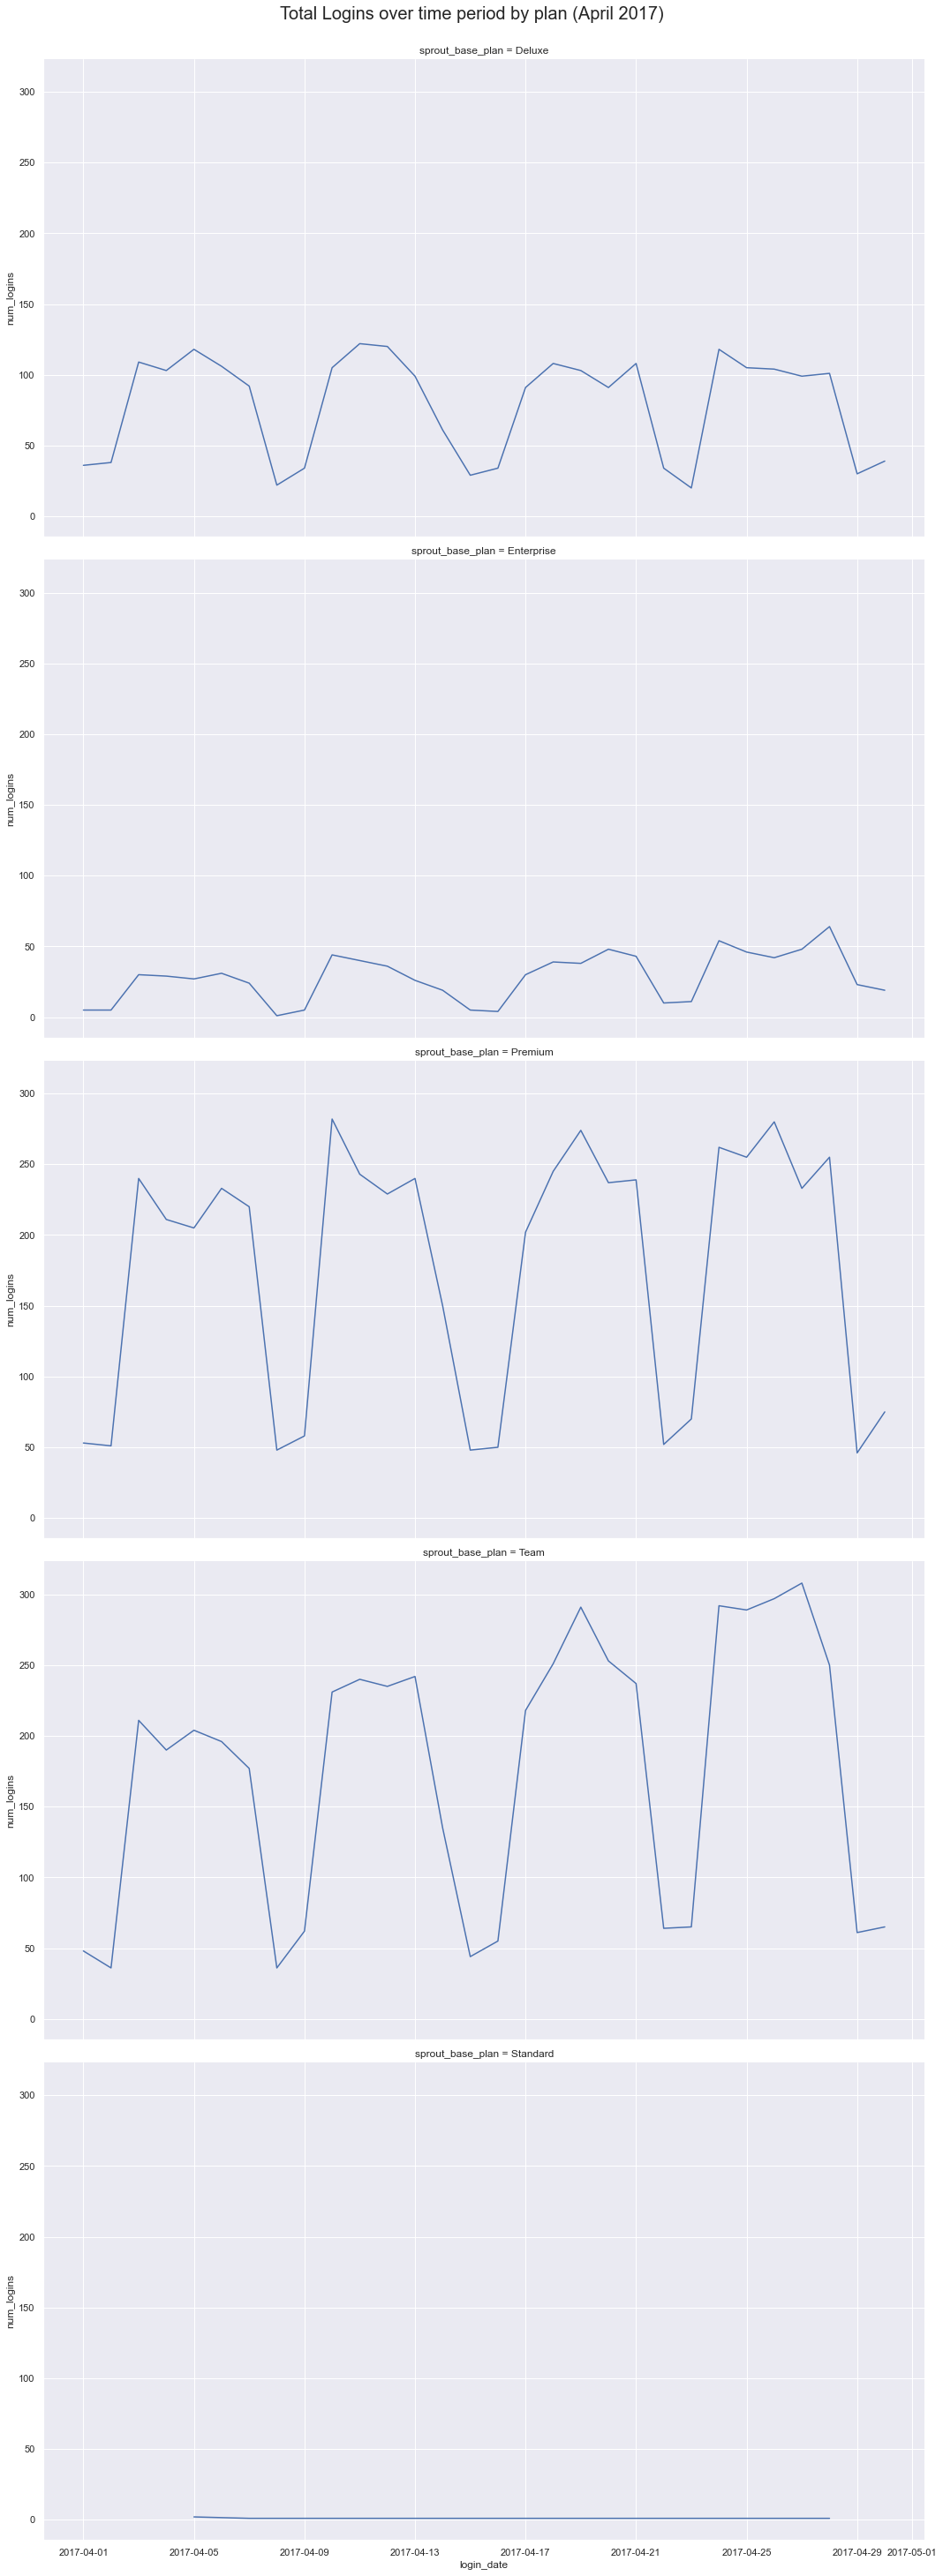

In [15]:
# Visualization of logins by plan type during the month of April
g = sns.relplot(data=logins_over_time_plan_type, 
                kind="line", 
                x='login_date',
                y="num_logins",
                row = 'sprout_base_plan',
                height=8.27, 
                aspect=15/8.27)

g.fig.subplots_adjust(top=0.96)
g.fig.suptitle('Total Logins over time period by plan (April 2017)', fontsize=20)
plt.show()

## 3) EXTRA CREDIT:  What is the cumulative distribution of total logins by customer? Approximately how many customers account for 90% of all logins?

In [16]:
# Creation of dataframe to medel total logins by customer id
logins_by_customer = (daily_logins.groupby(['customer_id'])['num_logins']
                      .count()
                      .to_frame())

logins_by_customer.head()

,num_logins
customer_id,
008335a1665d29963d7a5defbe3f299323073fd2,15
014c646bda2400ada426cda09666aa147fe5bf90,5
01587ee59093ae1c20b4a4f78f3edb1b2d263164,1
01f7e447d301a2cc037cdaf1ad84051860e9d66c,2
0262a2b579f9c01342220b56ad0a2b781653ce6c,29


### Visualization of cumulative distribution

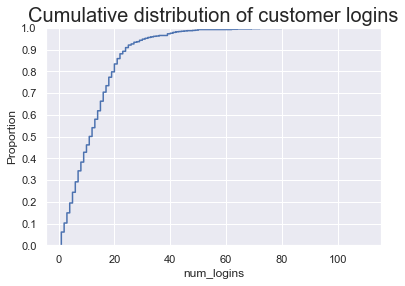

In [17]:
# Cumulative Distribution (ECDF Plot) of logins over the period
g = sns.ecdfplot(data=logins_by_customer, 
                 x='num_logins')

sns.set(rc={'figure.figsize':(15,8.27)})
plt.title('Cumulative distribution of customer logins', fontsize=20)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

### 3A) Computation of value at the 90th percentile. 24 Logins (or less)

In [18]:
percentile_series = logins_by_customer.quantile(q=.90)
value_at_ninety_percent = percentile_series.reset_index()
login_count_at_ninety_percent = value_at_ninety_percent[0.9].iloc[0]
login_count_at_ninety_percent

print("The number of logins at the 90th percentile is " + str(login_count_at_ninety_percent))

The number of logins at the 90th percentile is 24.0


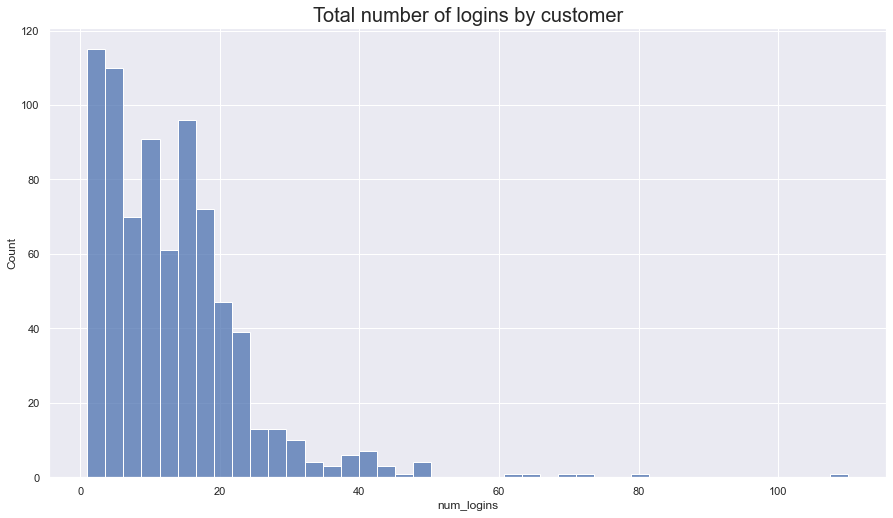

In [19]:
# Histogram of logins
sns.histplot(data=logins_by_customer, x='num_logins')

sns.set(rc={'figure.figsize':(15,8.27)})
plt.title('Total number of logins by customer', fontsize=20)
plt.show()

### 3B) Number of customers at or below the 90th percentile of logins. 701

In [20]:
# Number of customers constituting 90% (24 logins or less) of data frame
total_customers_for_ninety_percentile = logins_by_customer[logins_by_customer['num_logins'] <= login_count_at_ninety_percent].shape[0]

print("The number of customers with monthly logins less than or equal to the 90th percentile (24 logins) is " + str(total_customers_for_ninety_percentile))

The number of customers with monthly logins less than or equal to the 90th percentile (24 logins) is 701
